
# AIHC 5615 — Week 2 Homework (Python)
**Dataset:** King County, WA house prices (`kc_house_data.csv`)  
**Goal:** Exploratory analysis, simple linear regression, manual OLS, and bootstrapping.

> **Setup:** Put `kc_house_data.csv` somewhere accessible and update `DATA_PATH` below.


In [1]:

# === Imports & Setup ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from scipy import stats
import statsmodels.api as sm

# Matplotlib defaults (no custom colors/styles per instructions)
plt.rcParams.update({"figure.figsize": (7,5)})



## Problem 1 — Exploration

### 1. Import the data; identify variable types; convert categoricals


In [2]:

# === 1A: Import and types ===
# Update this path to where you placed the dataset
DATA_PATH = "/Users/codylewis/Desktop/AIHC 5615/Week 2/data/kc_house_data.csv"  
df = pd.read_csv(DATA_PATH)

print("Shape:", df.shape)
display(df.head())

# Identify variable types
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()

print("Numeric columns:", numeric_cols)
print("Non-numeric columns (to consider as categorical):", categorical_cols)

# Convert non-numeric to categorical
df["date"] = pd.to_datetime(df["date"])
df["id"] = df["id"].astype("category")
df["waterfront"] = df["waterfront"].astype("category")
df["view"] = df["view"].astype("category")
df["zipcode"] = df["zipcode"].astype("category")

df.info()


Shape: (21613, 21)


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


Numeric columns: ['id', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15']
Non-numeric columns (to consider as categorical): ['date']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             21613 non-null  category      
 1   date           21613 non-null  datetime64[ns]
 2   price          21613 non-null  float64       
 3   bedrooms       21613 non-null  int64         
 4   bathrooms      21613 non-null  float64       
 5   sqft_living    21613 non-null  int64         
 6   sqft_lot       21613 non-null  int64         
 7   floors         21613 non-null  float64       
 8   waterfront     21613 non-null  category      
 9   view       


### 2. Choose a numerical predictor; histograms, scatter; descriptive statistics
I will use sqft_living as the predictor for price.


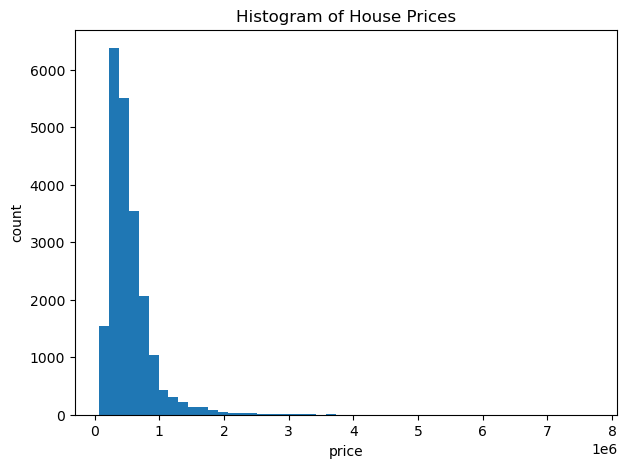

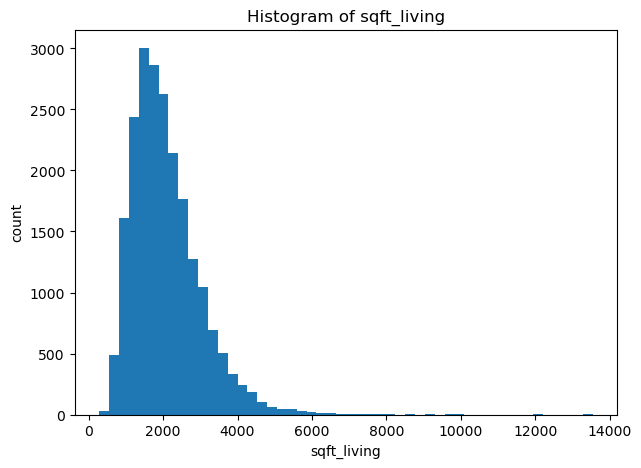

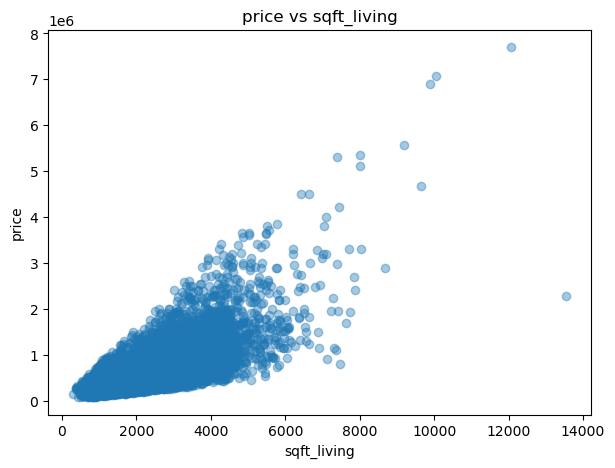

,count,mean,std,min,25%,50%,75%,max
price,21613.0,540088.141767,367127.196483,75000.0,321950.0,450000.0,645000.0,7700000.0
sqft_living,21613.0,2079.899736,918.440897,290.0,1427.0,1910.0,2550.0,13540.0


Correlation between sqft_living and price: 0.7020
Total observations: 21613
Median price: 450000.0
Median sqft_living: 1910.0


In [3]:

predictor = "sqft_living"
target = "price"

assert predictor in df.columns and target in df.columns, "Check predictor/target column names."

# Histograms (Matplotlib)
plt.hist(df[target].dropna(), bins=50)
plt.xlabel("price")
plt.ylabel("count")
plt.title("Histogram of House Prices")
plt.show()

plt.hist(df[predictor].dropna(), bins=50)
plt.xlabel(predictor)
plt.ylabel("count")
plt.title(f"Histogram of {predictor}")
plt.show()

# Scatter plot (Matplotlib)
plt.scatter(df[predictor], df[target], alpha=0.4)
plt.xlabel(predictor)
plt.ylabel(target)
plt.title(f"{target} vs {predictor}")
plt.show()

# Descriptive stats
display(df[[target, predictor]].describe().T)
corr = df[target].corr(df[predictor])
print(f"Correlation between {predictor} and {target}: {corr:.4f}")
print(f"Total observations: {len(df)}")
print("Median price:", df["price"].median())
print(f"Median {predictor}:", df[predictor].median())



### 3. Simple linear regression: `price ~ predictor`
Report fitted parameters and overlay regression line.


Slope: 280.623568
Intercept: -43580.743094
R^2: 0.4929


/opt/miniconda3/envs/ai-class/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


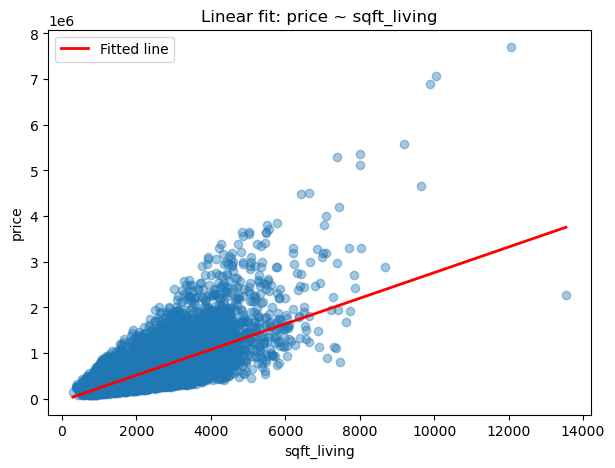

In [4]:

# Prepare data
X = df[[predictor]].dropna()
y = df.loc[X.index, target].dropna()
# Align indices (in case target had NaNs not in predictor)
X = X.loc[y.index]

lin = LinearRegression().fit(X, y)
slope, intercept = lin.coef_[0], lin.intercept_
r2 = lin.score(X, y)

print(f"Slope: {slope:.6f}")
print(f"Intercept: {intercept:.6f}")
print(f"R^2: {r2:.4f}")

# Plot with fitted line
x_line = np.linspace(X[predictor].min(), X[predictor].max(), 200).reshape(-1,1)
y_line = lin.predict(x_line)

plt.scatter(X[predictor], y, alpha=0.4)
plt.plot(x_line, y_line, color="red", linewidth=2, label="Fitted line")
plt.xlabel(predictor)
plt.ylabel(target)
plt.title(f"Linear fit: {target} ~ {predictor}")
plt.legend()
plt.show()

# Interpretation:
# - slope: expected change in price per change in squae feet of the home. As the sq feet goes up of the house, so does the price.
# - intercept: predicted price when sq feet = 0 



## Problem 2 — Assess Fit

1) Report standard errors and confidence intervals for parameters.  
2) Add four lines using CI edges for (intercept, slope) pairs.  
3) Briefly discuss fit quality.


=== Parameter Estimates (OLS) ===
Intercept (const): -43580.743094
Slope (sqft_living): 280.623568

=== Standard Errors ===
SE(intercept): 4402.689690
SE(slope):     1.936399

=== 95% Confidence Intervals ===
CI(intercept): [-52210.339639, -34951.146550]
CI(slope):     [276.828084, 284.419052]

R²: 0.4929


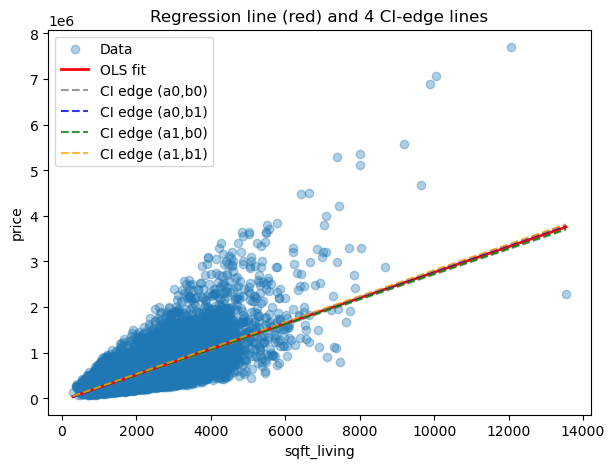

In [5]:
# === Problem 2: SEs, CIs, and 4 CI-edge lines with labeled legend ===
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Prepare aligned data
df_fit = df[[predictor, target]].dropna()
X = df_fit[[predictor]]
y = df_fit[target]

# Fit model with intercept
X_sm = sm.add_constant(X)
ols = sm.OLS(y, X_sm).fit()

# Extract parameter names safely
param_names = ols.params.index.tolist()
slope_name = [p for p in param_names if p != "const"][0]

# Standard errors and confidence intervals
se_intercept = ols.bse["const"]
se_slope = ols.bse[slope_name]
ci = ols.conf_int()
a0, a1 = ci.loc["const"].values
b0, b1 = ci.loc[slope_name].values

# Print key results
print("=== Parameter Estimates (OLS) ===")
print(f"Intercept (const): {ols.params['const']:.6f}")
print(f"Slope ({slope_name}): {ols.params[slope_name]:.6f}")
print("\n=== Standard Errors ===")
print(f"SE(intercept): {se_intercept:.6f}")
print(f"SE(slope):     {se_slope:.6f}")
print("\n=== 95% Confidence Intervals ===")
print(f"CI(intercept): [{a0:.6f}, {a1:.6f}]")
print(f"CI(slope):     [{b0:.6f}, {b1:.6f}]")
print(f"\nR²: {ols.rsquared:.4f}")

# Generate fitted and CI-edge lines
x_plot = np.linspace(X[predictor].min(), X[predictor].max(), 200)
y_fit = ols.params["const"] + ols.params[slope_name] * x_plot

plt.figure(figsize=(7,5))
plt.scatter(X[predictor], y, alpha=0.35, label="Data")

# Main regression line
plt.plot(x_plot, y_fit, color="red", linewidth=2, label="OLS fit")

# Plot the four CI-edge lines with distinct labels
plt.plot(x_plot, a0 + b0*x_plot, linestyle="--", color="gray", alpha=0.8, label="CI edge (a0,b0)")
plt.plot(x_plot, a0 + b1*x_plot, linestyle="--", color="blue", alpha=0.8, label="CI edge (a0,b1)")
plt.plot(x_plot, a1 + b0*x_plot, linestyle="--", color="green", alpha=0.8, label="CI edge (a1,b0)")
plt.plot(x_plot, a1 + b1*x_plot, linestyle="--", color="orange", alpha=0.8, label="CI edge (a1,b1)")

plt.xlabel(predictor)
plt.ylabel(target)
plt.title("Regression line (red) and 4 CI-edge lines")
plt.legend()
plt.show()


2.3
Overall, the model captures a clear positive relationship between home size and price but does not fully explain the data because price is affected by multiple variables. For a single-predictor model, the fit is reasonable, and the positive slope confirms the expected real-estate trend.

Problem 3 — Handle Anomalies / Outliers¶

Create a filtered dataframe by trimming extreme values (simple, transparent criteria), refit, and compare.

Original sample size: 21613
New sample size:      21431
Removed observations: 182


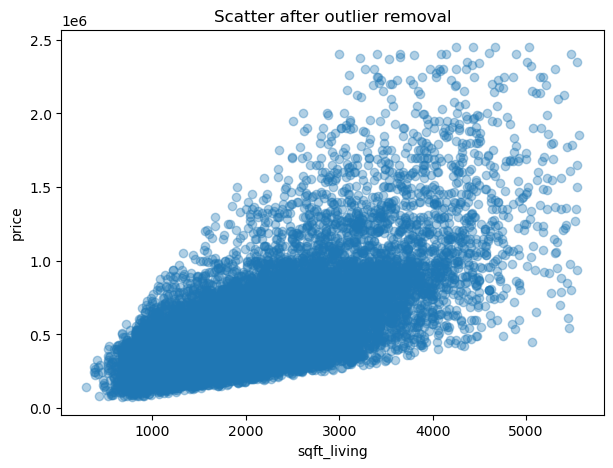

=== Cleaned-Data Model Results ===
Intercept (const): 30237.528819
Slope (sqft_living): 240.674649
SE(intercept): 4002.417742
SE(slope):     1.806851
95% CI(intercept): [22392.49108683 38082.56655199]
95% CI(slope):     [237.13308517 244.21621225]
R²: 0.4529


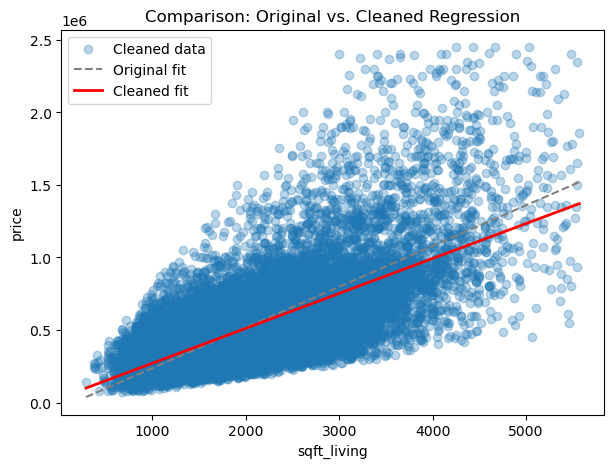

In [6]:
# === Problem 3: Handle Anomalies and Refit ===
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# 1️⃣ Define removal criteria
#    Trim extreme outliers in both predictor and price (top 0.5%)
crit = (
    (df[predictor] <= df[predictor].quantile(0.995)) &
    (df[target]     <= df[target].quantile(0.995))
)

df_clean = df.loc[crit].copy()
removed = len(df) - len(df_clean)

print(f"Original sample size: {len(df)}")
print(f"New sample size:      {len(df_clean)}")
print(f"Removed observations: {removed}")

# 2️⃣ Visualize the cleaned scatter
plt.figure(figsize=(7,5))
plt.scatter(df_clean[predictor], df_clean[target], alpha=0.35)
plt.title("Scatter after outlier removal")
plt.xlabel(predictor)
plt.ylabel(target)
plt.show()

# 3️⃣ Refit regression on cleaned data
Xc = sm.add_constant(df_clean[[predictor]])
yc = df_clean[target]
ols_clean = sm.OLS(yc, Xc).fit()

# 4️⃣ Report new estimates, SEs, and CIs
param_names = ols_clean.params.index.tolist()
slope_name = [p for p in param_names if p != "const"][0]

print("=== Cleaned-Data Model Results ===")
print(f"Intercept (const): {ols_clean.params['const']:.6f}")
print(f"Slope ({slope_name}): {ols_clean.params[slope_name]:.6f}")
print(f"SE(intercept): {ols_clean.bse['const']:.6f}")
print(f"SE(slope):     {ols_clean.bse[slope_name]:.6f}")
print(f"95% CI(intercept): {ols_clean.conf_int().loc['const'].values}")
print(f"95% CI(slope):     {ols_clean.conf_int().loc[slope_name].values}")
print(f"R²: {ols_clean.rsquared:.4f}")

# 5️⃣ Overlay new fit vs old fit for visual comparison
x_line = np.linspace(df_clean[predictor].min(), df_clean[predictor].max(), 200)
y_line_old = ols.params["const"] + ols.params[slope_name] * x_line
y_line_new = ols_clean.params["const"] + ols_clean.params[slope_name] * x_line

plt.figure(figsize=(7,5))
plt.scatter(df_clean[predictor], df_clean[target], alpha=0.3, label="Cleaned data")
plt.plot(x_line, y_line_old, color="gray", linestyle="--", label="Original fit")
plt.plot(x_line, y_line_new, color="red", linewidth=2, label="Cleaned fit")
plt.xlabel(predictor)
plt.ylabel(target)
plt.title("Comparison: Original vs. Cleaned Regression")
plt.legend()
plt.show()


3.3 
Compared to my original, the cleaned regression has a lower CI slope and much more realistic intercept as the original was in the negative values which makes no sense when buying a home as the land is worth money. Overall I find this to be a more accurate looking prediction.


## Problem 4 — Manual OLS (closed-form) function

Use the analytical formulas to compute slope and intercept and compare to OLS.


In [7]:

def linear_model(X_vec, Y_vec):
    X_arr = np.asarray(X_vec, dtype=float)
    Y_arr = np.asarray(Y_vec, dtype=float)
    x_bar = X_arr.mean()
    y_bar = Y_arr.mean()
    num = np.sum((X_arr - x_bar) * (Y_arr - y_bar))
    den = np.sum((X_arr - x_bar)**2)
    slope = num / den
    intercept = y_bar - slope * x_bar
    return slope, intercept

s_manual, a_manual = linear_model(Xc[predictor], yc)
print(f"Manual slope: {s_manual:.6f}, intercept: {a_manual:.6f}")
print("Compare to statsmodels (cleaned data):")
print(f"OLS slope: {ols_clean.params[predictor]:.6f}, intercept: {ols_clean.params['const']:.6f}")


Manual slope: 240.674649, intercept: 30237.528819
Compare to statsmodels (cleaned data):
OLS slope: 240.674649, intercept: 30237.528819



## Problem 5 — Bootstrap CIs for parameters

Resample the cleaned data with replacement, compute slope/intercept each time, and summarize.


Slope SE (bootstrap): 2.678440, 95% CI: [235.412070, 245.973891]
Intercept SE (bootstrap): 4777.414907, 95% CI: [20866.048963, 39530.504375]


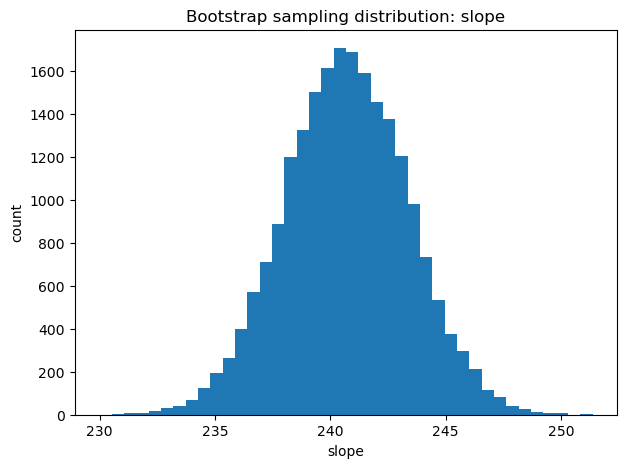

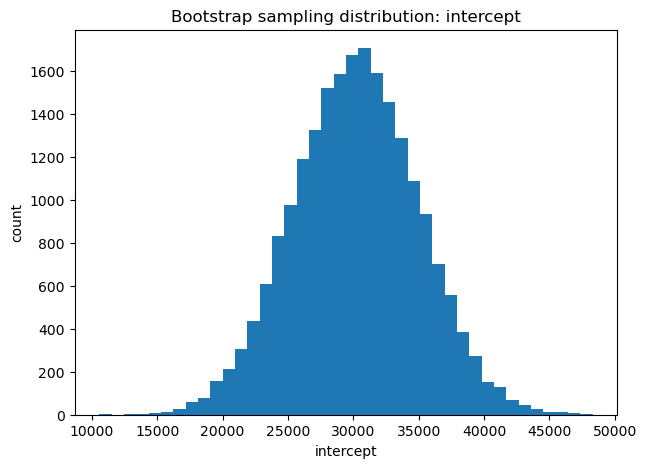

Bootstrap slope:   mean=240.694565, std=2.678440, IQR=3.639889
Bootstrap intercept: mean=30205.616380, std=4777.414907, IQR=6507.787684
Statsmodels slope SE:      1.806851
Statsmodels intercept SE:  4002.417742
Statsmodels slope 95% CI:      [237.13308517 244.21621225]
Statsmodels intercept 95% CI:  [22392.49108683 38082.56655199]
Bootstrap slope 95% CI:        [235.41207035 245.97389084]
Bootstrap intercept 95% CI:    [20866.0489629 39530.5043748]


In [8]:

rng = np.random.default_rng(42)
n_boot = max(len(Xc), 2000)
slopes, intercepts = [], []

X_vals = Xc[predictor].values
Y_vals = yc.values
n = len(X_vals)

for _ in range(n_boot):
    idx = rng.integers(0, n, n)
    s_b, a_b = linear_model(X_vals[idx], Y_vals[idx])
    slopes.append(s_b)
    intercepts.append(a_b)

slopes = np.array(slopes)
intercepts = np.array(intercepts)

se_slope = slopes.std(ddof=1)
se_intercept = intercepts.std(ddof=1)
ci_slope = np.percentile(slopes, [2.5, 97.5])
ci_intercept = np.percentile(intercepts, [2.5, 97.5])

print(f"Slope SE (bootstrap): {se_slope:.6f}, 95% CI: [{ci_slope[0]:.6f}, {ci_slope[1]:.6f}]")
print(f"Intercept SE (bootstrap): {se_intercept:.6f}, 95% CI: [{ci_intercept[0]:.6f}, {ci_intercept[1]:.6f}]")

# Histograms (Matplotlib)
plt.hist(slopes, bins=40)
plt.xlabel("slope")
plt.ylabel("count")
plt.title("Bootstrap sampling distribution: slope")
plt.show()

plt.hist(intercepts, bins=40)
plt.xlabel("intercept")
plt.ylabel("count")
plt.title("Bootstrap sampling distribution: intercept")
plt.show()

# Dispersion report
def iqr(a): 
    return np.percentile(a, 75) - np.percentile(a, 25)

print(f"Bootstrap slope:   mean={slopes.mean():.6f}, std={slopes.std(ddof=1):.6f}, IQR={iqr(slopes):.6f}")
print(f"Bootstrap intercept: mean={intercepts.mean():.6f}, std={intercepts.std(ddof=1):.6f}, IQR={iqr(intercepts):.6f}")

print(f"Statsmodels slope SE:      {ols_clean.bse[predictor]:.6f}")
print(f"Statsmodels intercept SE:  {ols_clean.bse['const']:.6f}")

print(f"Statsmodels slope 95% CI:      {ols_clean.conf_int().loc[predictor].values}")
print(f"Statsmodels intercept 95% CI:  {ols_clean.conf_int().loc['const'].values}")

print(f"Bootstrap slope 95% CI:        {ci_slope}")
print(f"Bootstrap intercept 95% CI:    {ci_intercept}")


The bootstrap estimates for both the slope and intercept were very similar to the values produced by the analytical (statsmodels) approach. The bootstrap slope had a standard error of about 2.68, compared to 1.81 from statsmodels, while the bootstrap intercept standard error was roughly 4,777 versus 4,002 from statsmodels. These differences are small relative to the magnitude of the parameters and indicate that both methods produce consistent estimates of variability.
The 95% confidence intervals were also closely aligned. For the slope, statsmodels gave a range of [237.13, 244.22], while bootstrapping produced [235.41, 245.97]—a slightly wider interval, as expected when using resampling. Similarly, the intercept CIs ([22,392 – 38,083] vs. [20,866 – 39,531]) overlapped substantially, suggesting that the bootstrap approach supports the same overall conclusions.
Overall, both methods indicate a statistically significant positive slope, confirming a strong positive relationship between square footage and price. The small differences in standard errors and confidence intervals mainly reflect that bootstrapping makes fewer assumptions about the underlying distribution and can capture slightly more sampling variability.